In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
from scipy.spatial.distance import mahalanobis
import heapq

# Load data

In [2]:
batch_num = 8
hidden_num = 25
step_num = 10
elem_num = 7
init_wins =20000 

names = [str(x) for x in range(elem_num)] +["label"]
forest = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/forest.csv",names=names,skiprows=step_num*init_wins)
classlabel = pd.read_csv("C:/Users/Bin/Documents/Datasets/forest cover/covtype.data",header=None,skiprows=step_num*init_wins).iloc[:,-1]

forest_tmp = forest[70000:270000]
classlabel_tmp = classlabel[70000:270000]
forest = pd.concat((forest[:70000],forest[270000:]),axis=0)
classlabel = pd.concat((classlabel[:70000],classlabel[270000:]),axis=0)
forest = pd.concat((forest,forest_tmp),axis=0)
classlabel = pd.concat((classlabel,classlabel_tmp),axis=0)
batches = forest.shape[0]//step_num//batch_num

test_set = forest.iloc[:batches*batch_num*step_num,:-1]
labels =forest.iloc[:batches*batch_num*step_num,-1]
cls = classlabel.iloc[:batches*batch_num*step_num]
ts = test_set.as_matrix().reshape(batches,batch_num,step_num,elem_num)
test_set_list = [ts[a] for a in range(batches)]
cl_list = [cls.as_matrix().reshape(batches,batch_num,step_num)[a] for a in range(batches)]

In [3]:
labels[labels!="normal"] = "anomaly"

In [4]:
del forest
del test_set

In [5]:
wins = batches * batch_num
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[3349, 3399, 3449, 3546, 3592, 3784, 3972, 4110, 4156, 4202, 4300, 4399, 4450, 4551, 4605, 4714, 4876, 4934, 5119, 5369, 5373, 5422, 5433, 5482, 5489, 5493, 5494, 5544, 5553, 5613, 5671, 5721, 5729, 5783, 5837, 5844, 5892, 5899, 5900, 5953, 5956, 6009, 6055, 6063, 6064, 6116, 6160, 6166, 6168, 6169, 6220, 6221, 6268, 6270, 6277, 6279, 6316, 6318, 6319, 6327, 6328, 6363, 6365, 6366, 6404, 6409, 6411, 6448, 6449, 6454, 6456, 6457, 6463, 6465, 6494, 6499, 6501, 6537, 6542, 6544, 6545, 6552, 6587, 6628, 6630, 6631, 6637, 6667, 6669, 6676, 6680, 6682, 6717, 6721, 6726, 6761, 6765, 6769, 6770, 6810, 6814, 6815, 6818, 6819, 6821, 6824, 6863, 6864, 6868, 6908, 6909, 6912, 6914, 6916, 6917, 6923, 6958, 6962, 6964, 6965, 6967, 6968, 6974, 18114, 18118, 18120, 18124, 18125, 18128, 18161, 18164, 18165, 18168, 18170, 18175, 18176, 18212, 18213, 18217, 18220, 18221, 18222, 18229, 18263, 18266, 18267, 18271, 18312, 18314, 18317, 18318, 18321, 18322, 18328, 18364, 18371, 18374, 18375, 18423, 18424, 18

# Load Model

In [6]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/forest_8_25_10/"
modelmeta_p = modelpath_root + "_8_25_10_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/forest_8_25_10/_8_25_10_para.ckpt


In [7]:
print(mu.shape,sigma.shape,threshold)

(7,) (7, 7) 0.00652888


# Online Phase (With expert)

In [8]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [9]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [10]:
def get_musigma(err_nbuf,mu,sigma):       
    
        err_vec_array = np.array(err_nbuf)
        # for multivariate  data
        mu = np.mean(err_vec_array,axis=0)
        sigma = np.cov(err_vec_array.T)
        return mu, sigma

In [11]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = lower
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate += delta 
        return threshold

In [12]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


100
200
300
400
retrain at 419 batch
Parameters updated! new threshold 0.007


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


500
600
700
800
900
1000
1100
1200
1300
retrain at 1357 batch
Parameters updated! new threshold 0.007
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
retrain at 2657 batch
Parameters updated! new threshold 0.007
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
retrain at 4095 batch
Parameters updated! new threshold 0.007
4100
4200
4300
4400
4500
4600
4700


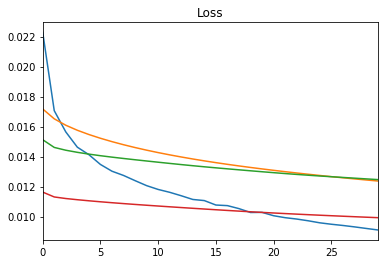

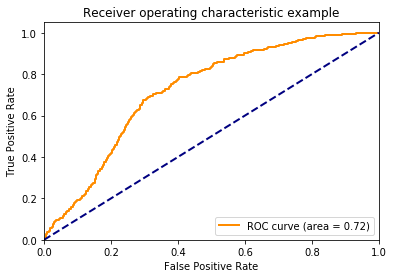

--- Initialization time: 339.9681680202484 seconds ---


In [13]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []
cl_buf_tmp = []
cl_buf = []
cl_notin_buf_tmp = []
cl_notin_buf = []
start_time = time.time()
for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for ids in range(len(test_set_list)):
#for data in test_set_list:
        data = test_set_list[ids]
        cl = cl_list[ids]
        
        if count % 100 == 0:
            print(count)
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
        
#       for index,value in enumerate(pd.DataFrame(pred)):
        for i in range(pd.DataFrame(pred).shape[0]):#loop batch_num
            index = i
            value=pd.DataFrame(pred).iloc[i,:]
            
            if value[value>threshold].size>=4: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    #err_abuf.append(e[index*step_num:(index+1)*step_num])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    err_nbuf =np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    
                    n_buf += [df[index,x,:] for x in range(step_num)]
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    cl_notin_buf_tmp += [cl[index,x] for x in range(step_num)]
                    #err_nbuf.append(e[index])
                    err_nbuf = np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    #print("TN")
        count +=1
        
        
        #n_buf = list(np.concatenate(n_buf,axis=0)) if len(n_buf) != 0 else list(n_buf)
        #a_buf = list(np.concatenate(a_buf,axis=0)) if len(a_buf) != 0 else list(a_buf)
        
        if len(n_buf)>=batch_num*step_num*400 and len(a_buf) !=0:
            while (len(a_buf) < batch_num*step_num):
                a_buf += a_buf
            
            B = len(n_buf) //(batch_num*step_num)
            n_buf = n_buf[:batch_num*step_num*B]
            A = len(a_buf)//(batch_num*step_num)
            a_buf = a_buf[:batch_num*step_num*A]
            
            print("retrain at %d batch"%count)
            loss_list_all=[]

            #datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            datalist = np.array(n_buf[:batch_num*step_num*(B-1)]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[batch_num*step_num*(B-1):]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            
            #err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            #mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)   

      

            print("Parameters updated! new threshold %.3f"%threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
            err_nbuf = []
            err_abuf = []
            cl_buf.append(cl_buf_tmp)
            cl_buf_tmp = []
            cl_notin_buf.append(cl_notin_buf_tmp)
            cl_notin_buf_tmp = []
cl_buf.append(cl_buf_tmp)
cl_notin_buf.append(cl_notin_buf_tmp)

fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))

In [70]:
sub_cl_buf + sub_ncl_buf

1    32782.0
2    16506.0
3       75.0
4        NaN
5      180.0
6      278.0
7     3539.0
dtype: float64

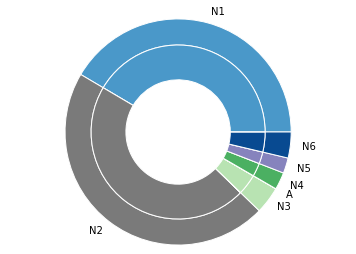

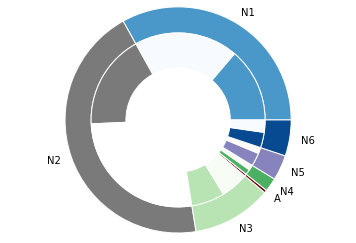

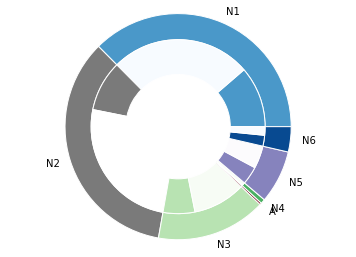

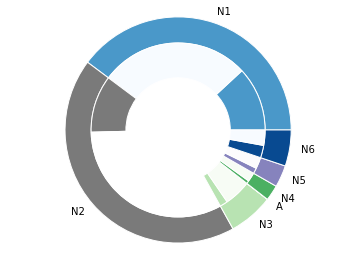

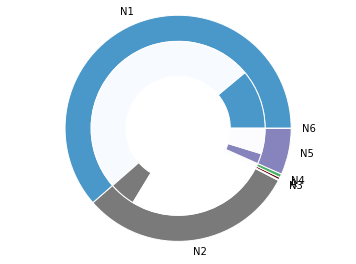

In [71]:
for ii in range(len(cl_buf)):
    sub_cl_buf = pd.Series(cl_buf[ii]).value_counts().sort_index()
    sub_ncl_buf =  pd.Series(cl_notin_buf[ii]).value_counts().sort_index()
    for tmp in range(1,sub_cl_buf.shape[0]+1):
        if tmp not in sub_cl_buf.index:
            sub_cl_buf[tmp] = 0
    
    for tmp in range(1,sub_cl_buf.shape[0]+1):
        if tmp not in sub_ncl_buf.index:
            sub_ncl_buf[tmp] = 0
    donutplot(sub_cl_buf.as_matrix(),(sub_cl_buf + sub_ncl_buf).fillna(0).astype(int).as_matrix(),1)

In [31]:
for foo in cl_buf:
    print(pd.Series(foo).value_counts())

2    15487
1    13914
3     1301
7     1242
5      828
6      737
4        1
dtype: int64
2    13235
1    10337
3     4646
7     2143
6     1847
5      745
4      297
dtype: int64
1    11787
2     9787
3     6142
6     3512
7     2094
4      282
5      126
dtype: int64
1    13698
2    12222
7     2649
3     1677
6     1193
5      634
4        7
dtype: int64
1    5904
2    2600
7    1019
6     100
5      36
3      21
dtype: int64


In [17]:
for bar in cl_notin_buf:
    print(pd.Series(bar).value_counts())

2    10
dtype: int64
2    20125
1    14487
3     3875
7     1718
6      855
5      730
dtype: int64
1    27147
2    26385
3    10173
6     4376
7     1653
5      536
dtype: int64
2    37577
1    32068
3     5705
7     3283
6     2409
5     1918
dtype: int64
1    26878
2    13906
7     2520
6      178
5      144
3       54
dtype: int64


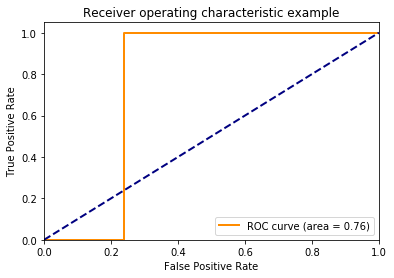

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(expert[:419*8], output[:419*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

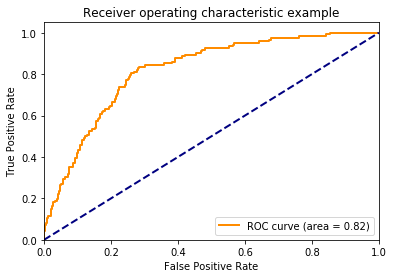

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(expert[419*8:1295*8], output[419*8:1295*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

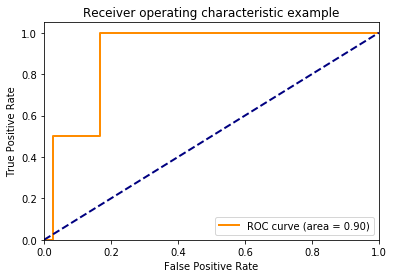

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(expert[1295*8:2265*8], output[1295*8:2265*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

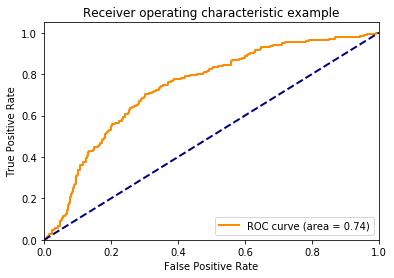

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(expert[2265*8:], output[2265*8:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

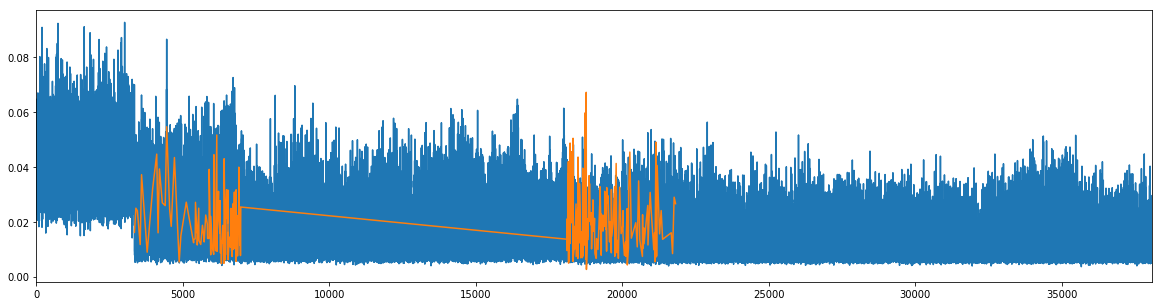

In [18]:

pd.Series(np.array(output)).plot(figsize=(20,5))
pd.Series(np.array(all_scores).ravel())[anomaly_index].plot(figsize=(20,5))

In [70]:
classlabel[20000*10:].shape


(181012,)

In [21]:

def donutplot(retrain,everseen,p):

    group_names=['N1', 'N2', 'N3',"A",'N4', 'N5', 'N6']
    group_size=everseen
    subgroup_names=['', '', '', '', '', '','', '', '', '', '', '','','']
    subgroup_size=[]
    
    for i in range(len(retrain)):
        subgroup_size += [retrain[i],everseen[i]-retrain[i]]

    # Create colors
    a, b, c,d,e,f,g=[plt.cm.Blues, plt.cm.Greys, plt.cm.Greens, plt.cm.Reds, plt.cm.Greens,plt.cm.Purples,plt.cm.Blues]

    # First Ring (outside)
    fig, ax = plt.subplots()
    ax.axis('equal')
    mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.3),d(1.0),e(0.6),f(0.6),g(0.9)] )
    plt.setp( mypie, width=0.3, edgecolor='white')

    # Second Ring (Inside)
    if p != 0:
        mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.6), a(0), b(0.6), b(0), c(0.3), c(0),d(1.0),d(0),e(0.6),e(0),f(0.6),f(0),g(0.9),g(0)])
        plt.setp( mypie2, width=0.4, edgecolor='white')
        plt.margins(0,0)
    else:
        mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0), a(0), b(0), b(0), c(0), c(0),d(0),d(0),e(0),e(0),f(0),f(0),g(0),g(0)])
        plt.setp( mypie2, width=0.4, edgecolor='white')
        plt.margins(0,0)
    # show it
    plt.show()

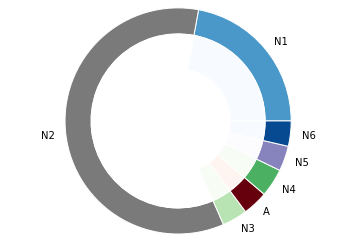

KeyError: 0

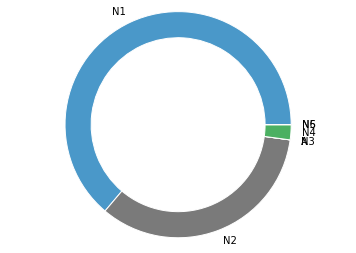

In [29]:

streamfragsize =[[13259, 35685, 2160, 2160, 2416, 2160, 2160] ] # initialization set statistic
retrain_stat = [[13259, 35685, 2160, 2160, 2416, 2160, 2160]]
classlabel_online = classlabel

retrain_pos = [0,4190,13570,26570,40950]

for i in range(len(retrain_pos)-1):
    a = retrain_pos[i]
    b = retrain_pos[i+1]
    df = classlabel_online[a:b].value_counts()
    for tmp in range(7):
        if tmp+1 not in df:
            df[tmp+1] = 0
    streamfragsize.append([df[k+1] for k in range(7)])

for vv in cl_buf:
    retrain_stat.append([pd.Series(vv[i+1]).value_counts() for i in range(7)])

for i in range(len(retrain_stat)):
    everseen = streamfragsize[i]

    retrain_ = retrain_stat[i]
    donutplot(retrain_,everseen,i)

# Without retraining

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


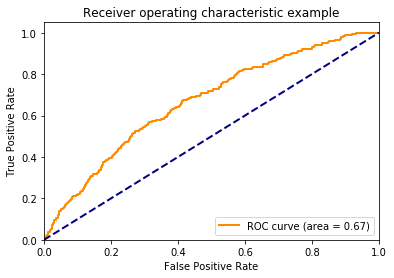

--- Initialization time: 67.81702709197998 seconds ---


In [33]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []

start_time = time.time()
for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
 
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))

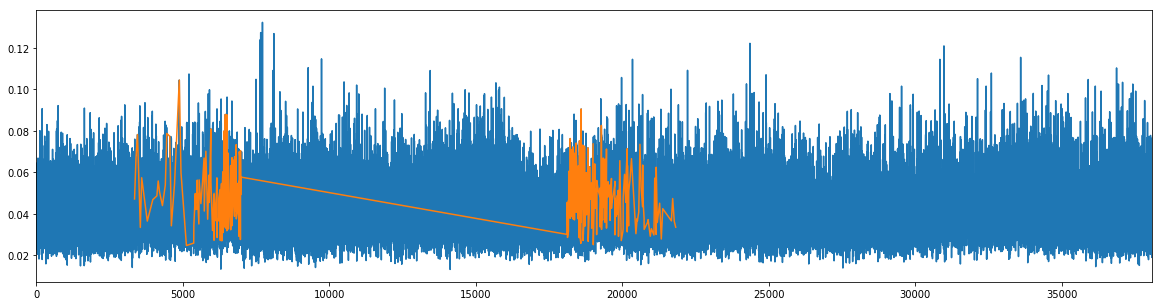

In [38]:

pd.Series(output).plot(figsize=(20,5))
pd.Series(output)[anomaly_index].plot()

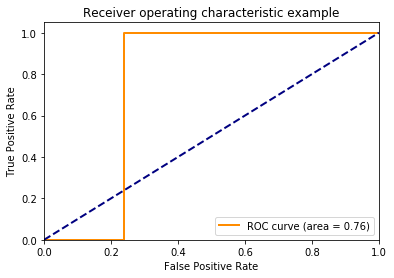

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(expert[:419*8], output[:419*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

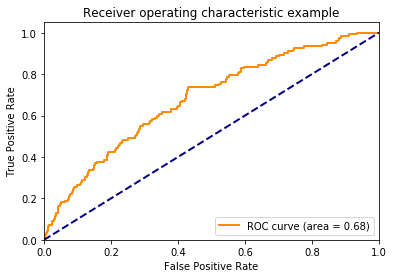

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(expert[419*8:1295*8], output[419*8:1295*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

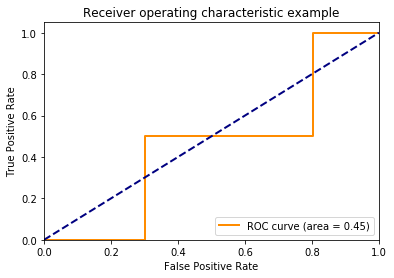

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(expert[1295*8:2265*8], output[1295*8:2265*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

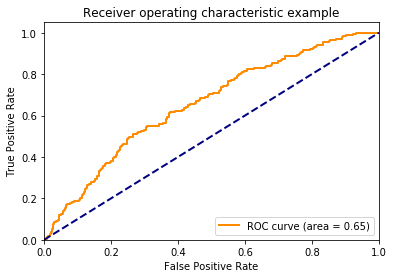

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(expert[2265*8:], output[2265*8:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)